#Upload Dataset

In [24]:
import pandas as pd
import sqlite3
import os

folder_path = '/content/drive/My Drive/Colab Notebooks/Hospital Project'

try:
    os.chdir(folder_path)
    print(f"Current Working Directory: {os.getcwd()}")
except FileNotFoundError:
    print("Error: Path not found. Check your folder name in Google Drive.")

file_name = 'Hospital ER_Data.csv'
df = pd.read_csv(file_name)

Current Working Directory: /content/drive/My Drive/Colab Notebooks/Hospital Project


# CLEANUP: Fix Column Names for SQL & Create the SQL Database & Test

In [25]:
# change "Patient ID" -> "patient_id" so SQL doesn't break
db_name = 'hospital.db'
conn = sqlite3.connect(db_name)

# save Data to SQL
df.to_sql('er_visits', conn, if_exists='replace', index=False)

# test
test_query = "SELECT * FROM er_visits LIMIT 3;"
test_df = pd.read_sql(test_query, conn)
conn.close
test_df

,Patient Id,Patient Admission Date,Patient First Inital,Patient Last Name,Patient Gender,Patient Age,Patient Race,Department Referral,Patient Admission Flag,Patient Satisfaction Score,Patient Waittime,Patients CM
0,145-39-5406,20-03-2024 08:47,H,Glasspool,M,69,White,None,0,10.0,39,0
1,316-34-3057,15-06-2024 11:29,X,Methuen,M,4,Native American/Alaska Native,None,1,NaN,27,0
2,897-46-3852,20-06-2024 09:13,P,Schubuser,F,56,African American,General Practice,1,9.0,55,0


In [26]:
#Calculate the "Wait Time" as  "Wait Time"

In [27]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect('hospital.db')

# --- 1. Load the raw data (We removed the strftime part) ---
query = """
SELECT
    "Patient Admission Date" as date,
    "Patient Gender" as patient_gender,
    "Patient Race" as patient_race,
    "Patient Admission Flag" as patient_admin_flag,
    "Patient Waittime" as patient_waittime,
    "Department Referral" as department_referral
FROM er_visits
"""

df_analysis = pd.read_sql(query, conn)

# dayfirst=True tells Python that the date is DD-MM-YYYY
df_analysis['date'] = pd.to_datetime(df_analysis['date'], dayfirst=True)
df_analysis['arrival_hour'] = df_analysis['date'].dt.hour

print(df_analysis[['date', 'arrival_hour', 'patient_waittime']].head())


                 date  arrival_hour  patient_waittime
0 2024-03-20 08:47:00             8                39
1 2024-06-15 11:29:00            11                27
2 2024-06-20 09:13:00             9                55
3 2024-02-04 22:34:00            22                31
4 2024-09-04 17:48:00            17                10


#Visualizing the Bottlenecks

/tmp/ipython-input-1137603095.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_analysis, x='arrival_hour', palette='viridis')


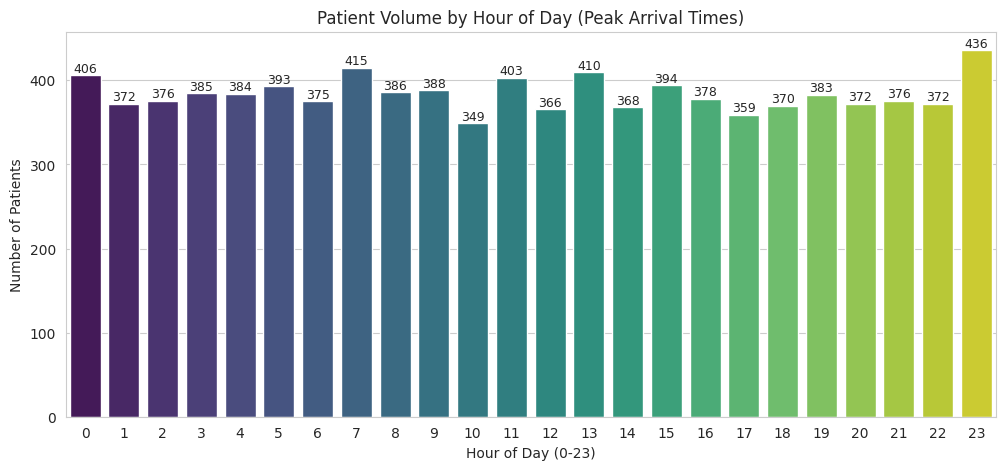

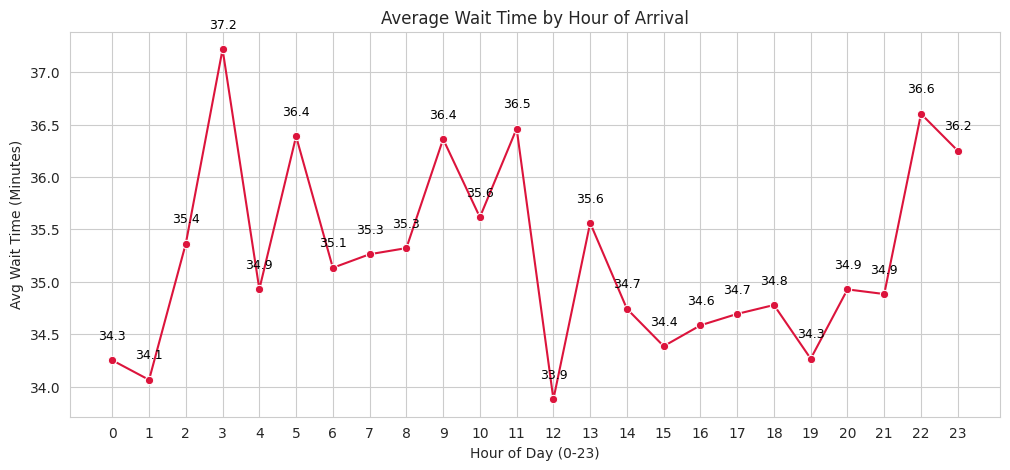

/tmp/ipython-input-1137603095.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_analysis, x='department_referral', y='patient_waittime', palette='magma', errorbar=None)


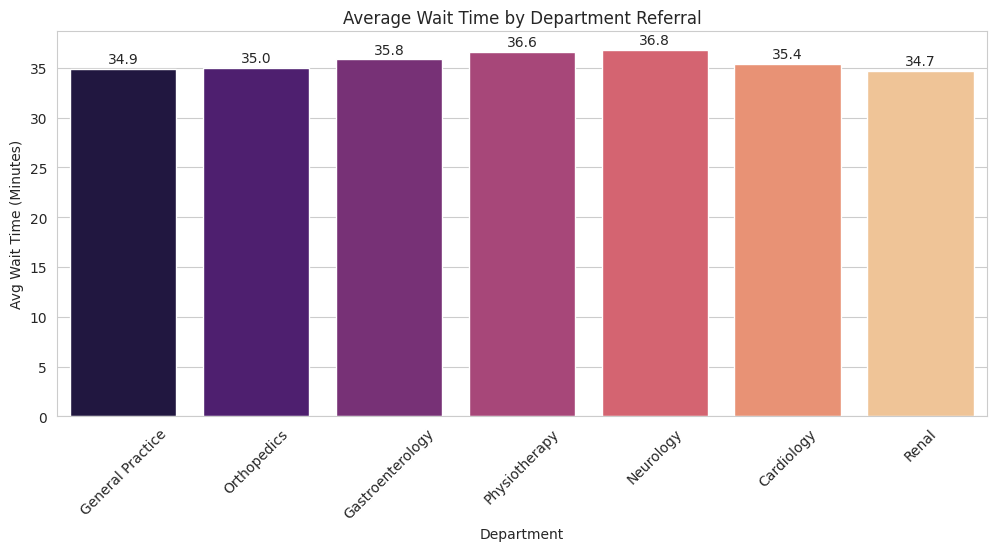

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# --- 1. PEAK HOURS (Countplot) ---
plt.figure(figsize=(12, 5))

ax = sns.countplot(data=df_analysis, x='arrival_hour', palette='viridis')
plt.title('Patient Volume by Hour of Day (Peak Arrival Times)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Patients')

for container in ax.containers:
    ax.bar_label(container, fontsize=9)

plt.show()


# --- 2. WAIT TIME TRENDS (Lineplot) ---
hourly_means = df_analysis.groupby('arrival_hour')['patient_waittime'].mean().reset_index()

plt.figure(figsize=(12, 5))
# errorbar=None removes the shading so text is readable
sns.lineplot(data=df_analysis, x='arrival_hour', y='patient_waittime', marker='o', color='crimson', errorbar=None)

plt.title('Average Wait Time by Hour of Arrival')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Avg Wait Time (Minutes)')
plt.xticks(range(0, 24))

for index, row in hourly_means.iterrows():
    plt.text(
        x=row['arrival_hour'],
        y=row['patient_waittime'] + 0.2, # Shift text slightly up
        s=f"{row['patient_waittime']:.1f}", # Format to 1 decimal
        color='black',
        ha='center',
        fontsize=9
    )

plt.show()


# --- 3. DEPARTMENT STRESS (Barplot) ---
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=df_analysis, x='department_referral', y='patient_waittime', palette='magma', errorbar=None)

plt.title('Average Wait Time by Department Referral')
plt.xlabel('Department')
plt.ylabel('Avg Wait Time (Minutes)')
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=2, fontsize=10)

plt.show()


#When the hospital is most stressed(what time in what day?)

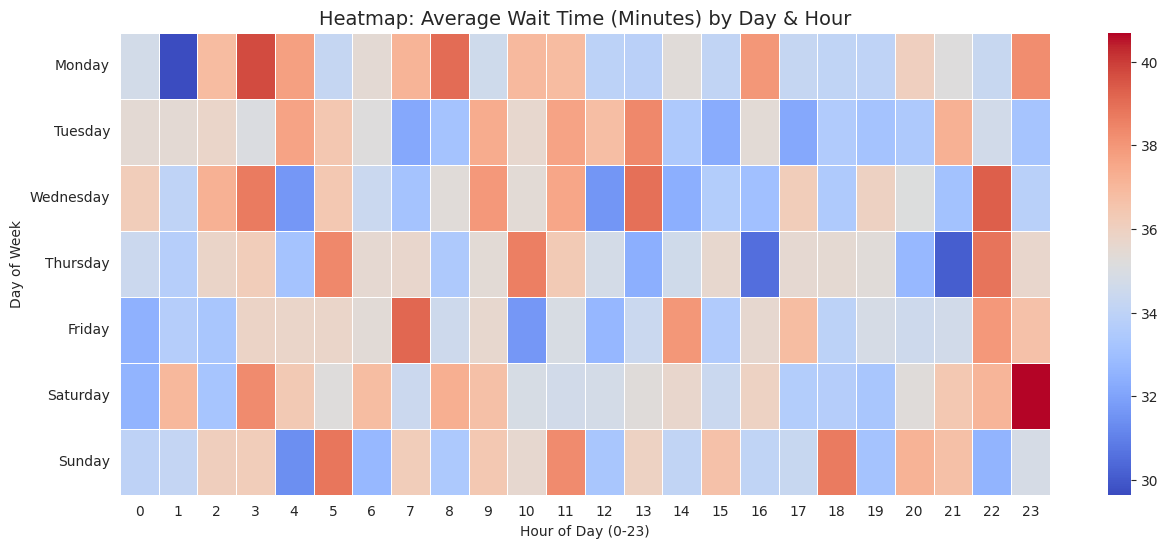

/tmp/ipython-input-2442842793.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='department_referral', y='patient_waittime', palette='Set2')


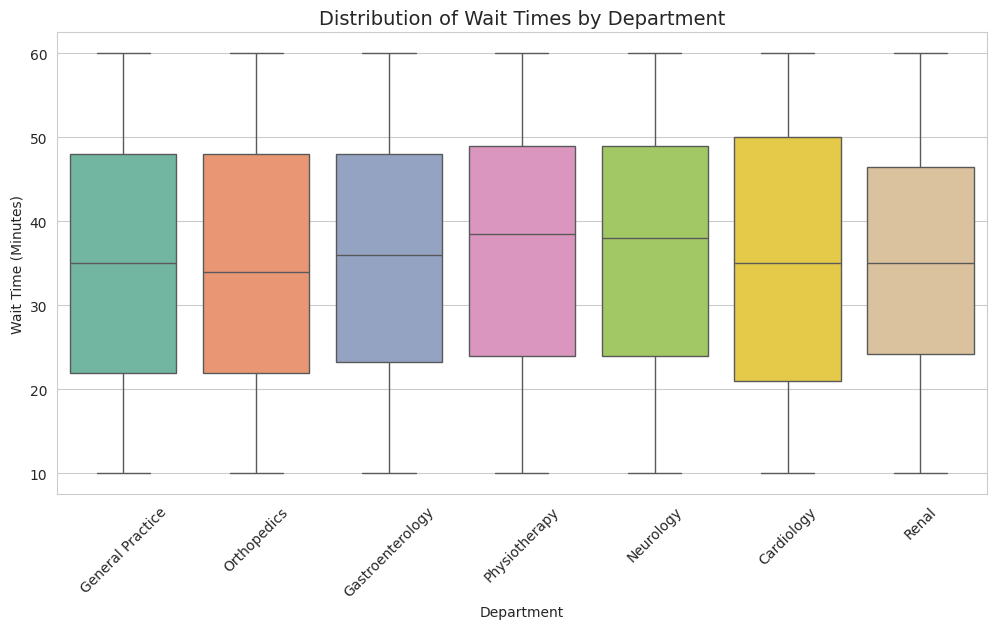

In [29]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect('hospital.db')
query = """
SELECT
    "Patient Admission Date" as date,
    "Patient Waittime" as patient_waittime,
    "Department Referral" as department_referral
FROM er_visits
"""
df = pd.read_sql(query, conn)
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

df['hour'] = df['date'].dt.hour
df['day_name'] = df['date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# ==========================================
# VISUALIZATION 1: The Heatmap
# ==========================================
# We need a matrix: Rows = Day, Cols = Hour, Values = Avg Wait Time
pivot_table = df.pivot_table(
    index='day_name',
    columns='hour',
    values='patient_waittime',
    aggfunc='mean'
)

# Reorder the index to be Mon-Sun
pivot_table = pivot_table.reindex(day_order)

plt.figure(figsize=(15, 6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=False, linewidths=.5)
plt.title('Heatmap: Average Wait Time (Minutes) by Day & Hour', fontsize=14)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Day of Week')
plt.show()

# ==========================================
# VISUALIZATION 2: Boxplot (Distribution)
# ==========================================
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='department_referral', y='patient_waittime', palette='Set2')

plt.title('Distribution of Wait Times by Department', fontsize=14)
plt.xlabel('Department')
plt.ylabel('Wait Time (Minutes)')
plt.xticks(rotation=45)
plt.show()


## Build Prophet model to predict patient inflow for next 7 days

In [30]:
!pip install prophet

/tmp/ipython-input-1959692203.py:15: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_raw['ds'] = pd.to_datetime(df_raw['Patient Admission Date'])
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Total raw rows found: 9216
Daily aggregated rows: 579
          ds   y
0 2023-04-01  19
1 2023-04-02  13
2 2023-04-03  14
3 2023-04-04   9
4 2023-04-05  19

--- Predicted Patient Count (Next 7 Days) ---
            ds       yhat  yhat_lower  yhat_upper
579 2024-10-31  16.445339   11.663361   21.494431
580 2024-11-01  16.176967   11.523478   21.034046
581 2024-11-02  16.794375   12.283124   21.945278
582 2024-11-03  16.083314   11.500810   20.908365
583 2024-11-04  16.035120   10.986608   20.625533
584 2024-11-05  15.926667   11.183759   20.801345
585 2024-11-06  15.384335   10.434910   20.184577


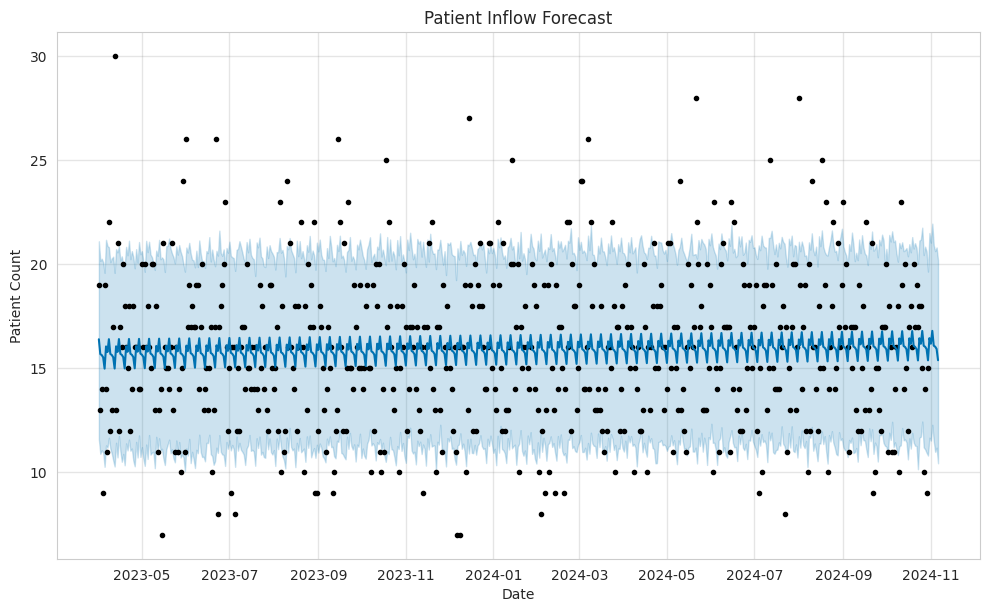

In [31]:
import sqlite3
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

conn = sqlite3.connect('hospital.db')

df_raw = pd.read_sql('SELECT "Patient Admission Date" FROM er_visits', conn)

print(f"Total raw rows found: {len(df_raw)}")
if len(df_raw) == 0:
    print("CRITICAL ERROR: The table is empty. Please re-run the 'Rebuild Database' step.")
else:
    # Use Pandas to handle the dates (Much more robust than SQL)
    df_raw['ds'] = pd.to_datetime(df_raw['Patient Admission Date'])

    # Group by Day (resample) to get daily counts(y)
    df = df_raw.set_index('ds').resample('D').size().reset_index(name='y')

    print(f"Daily aggregated rows: {len(df)}")
    print(df.head())#Sample

    # run Prophet
    m = Prophet(daily_seasonality=True)
    m.fit(df)

    # Predict Next 7 Days
    future = m.make_future_dataframe(periods=7)
    forecast = m.predict(future)

    # Show Forecast
    print("\n--- Predicted Patient Count (Next 7 Days) ---")
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7))

    # Plot
    m.plot(forecast)
    plt.title("Patient Inflow Forecast")
    plt.xlabel("Date")
    plt.ylabel("Patient Count")
    plt.show()


Black dots: The actual data (history).
Blue line: The model's "trend" line--- around 16 patients per day
Light Blue shading: The "Confidence Interval" -- I am 80% sure the real number will be somewhere inside this blue cloud (between 11 and 21).

#Calculate Error Metrics (RMSE/MAE) for model

In [32]:
from prophet.diagnostics import cross_validation, performance_metrics

print("1. Starting Cross Validation (Testing the model against the past)...")
# Cut the data into pieces to test how well it predicts "unseen" data, start training with 180 years, then 30 days, then predicting 7 days
df_cv = cross_validation(m, initial='180 days', period='30 days', horizon='7 days')

print("2. Calculating Performance Metrics...")
df_p = performance_metrics(df_cv)

# RMSE (Root Mean Squared Error)
print("\n--- MODEL ACCURACY REPORT ---")
print(df_p[['horizon', 'rmse', 'mae']].head())

# average error across all tests
avg_error = df_p['rmse'].mean()
print(f"\nYour Model's Average Error: +/- {avg_error:.2f} patients")


INFO:prophet:Making 14 forecasts with cutoffs between 2023-09-29 00:00:00 and 2024-10-23 00:00:00


1. Starting Cross Validation (Testing the model against the past)...


  0%|          | 0/14 [00:00<?, ?it/s]

2. Calculating Performance Metrics...

--- MODEL ACCURACY REPORT ---
  horizon      rmse       mae
0  1 days  3.011509  2.488908
1  2 days  2.737574  2.264272
2  3 days  2.288276  1.890793
3  4 days  3.446022  2.992402
4  5 days  2.964006  2.234741

Your Model's Average Error: +/- 3.33 patients


Conclusion for accuracy:

1. 3.33/16 aprroximately 20% error which is stardard for human behavior;

2. To get the error down to +/- 1 patient, I would need external data (like local flu reports, weather forecasts, or holiday schedules).

3. The range is +/- 3 is much better than guessing. So staff for 16 patients, but keep one nurse on call in case we hit the upper range of 19

#Calculate required Nurse-to-Patient ratios based on forecast

Setting Starndard:
1. Nurse-to-Patient Ratio: 1:4 (One nurse can handle 4 patients safely).
2. Shift Duration: 12 hours (Standard nursing shift).
3. Nurse Cost: $50/hour (Estimated fully loaded cost).
4. The Baseline: Without AI, hospitals often staff for the "worst-case scenario" to be safe. We will assume the hospital currently schedules 6 nurses every day (enough for 24 patients) just to be safe.

In [33]:
import numpy as np

NURSE_RATIO = 4
SHIFT_HOURS = 12
HOURLY_WAGE = 50

# We take the forecast
staffing_df = forecast[['ds', 'yhat']].tail(30).copy() # next 30 days
staffing_df.columns = ['Date', 'Predicted_Patients']

# We divide patients by 4.
# We use np.ceil (ceiling) for round up number as integer
staffing_df['Nurses_Needed'] = np.ceil(staffing_df['Predicted_Patients'] / NURSE_RATIO)

# Baseline
staffing_df['Nurses_Current'] = 6

staffing_df['Cost_predicted'] = staffing_df['Nurses_Needed'] * SHIFT_HOURS * HOURLY_WAGE
staffing_df['Cost_Current'] = staffing_df['Nurses_Current'] * SHIFT_HOURS * HOURLY_WAGE

# SAVINGS
staffing_df['Daily_Savings'] = staffing_df['Cost_Current'] - staffing_df['Cost_predicted']

# Show sample schedule
print(staffing_df[['Date', 'Predicted_Patients', 'Nurses_Needed', 'Daily_Savings']].head(7))


          Date  Predicted_Patients  Nurses_Needed  Daily_Savings
556 2024-10-08           15.907199            4.0         1200.0
557 2024-10-09           15.364868            4.0         1200.0
558 2024-10-10           16.430738            5.0          600.0
559 2024-10-11           16.162366            5.0          600.0
560 2024-10-12           16.779775            5.0          600.0
561 2024-10-13           16.068713            5.0          600.0
562 2024-10-14           16.020520            5.0          600.0


#ROI

In [34]:
# Calculate Total Monthly Savings
total_monthly_savings = staffing_df['Daily_Savings'].sum()

# Estimate Annual Savings (Monthly * 12)
annual_savings_projected = total_monthly_savings * 12

print("=== EXECUTIVE SUMMARY ===")
print(f"Total Predicted Savings for Next 30 Days: ${total_monthly_savings:,.2f}")
print(f"Projected Annual Savings: ${annual_savings_projected:,.2f}")
print("=========================")


=== EXECUTIVE SUMMARY ===
Total Predicted Savings for Next 30 Days: $24,000.00
Projected Annual Savings: $288,000.00


In [35]:
# Clean up the table for export
final_schedule = staffing_df[['Date', 'Predicted_Patients', 'Nurses_Needed', 'Daily_Savings']]
final_schedule.columns = ['Date', 'Expected_Patients', 'Staff_to_Schedule', 'Savings_vs_Baseline']

# Save to CSV
final_schedule.to_csv('final_staffing_schedule.csv', index=False)

print("✅ Schedule saved as 'final_staffing_schedule.csv'")


✅ Schedule saved as 'final_staffing_schedule.csv'


#Dashbord as webpage

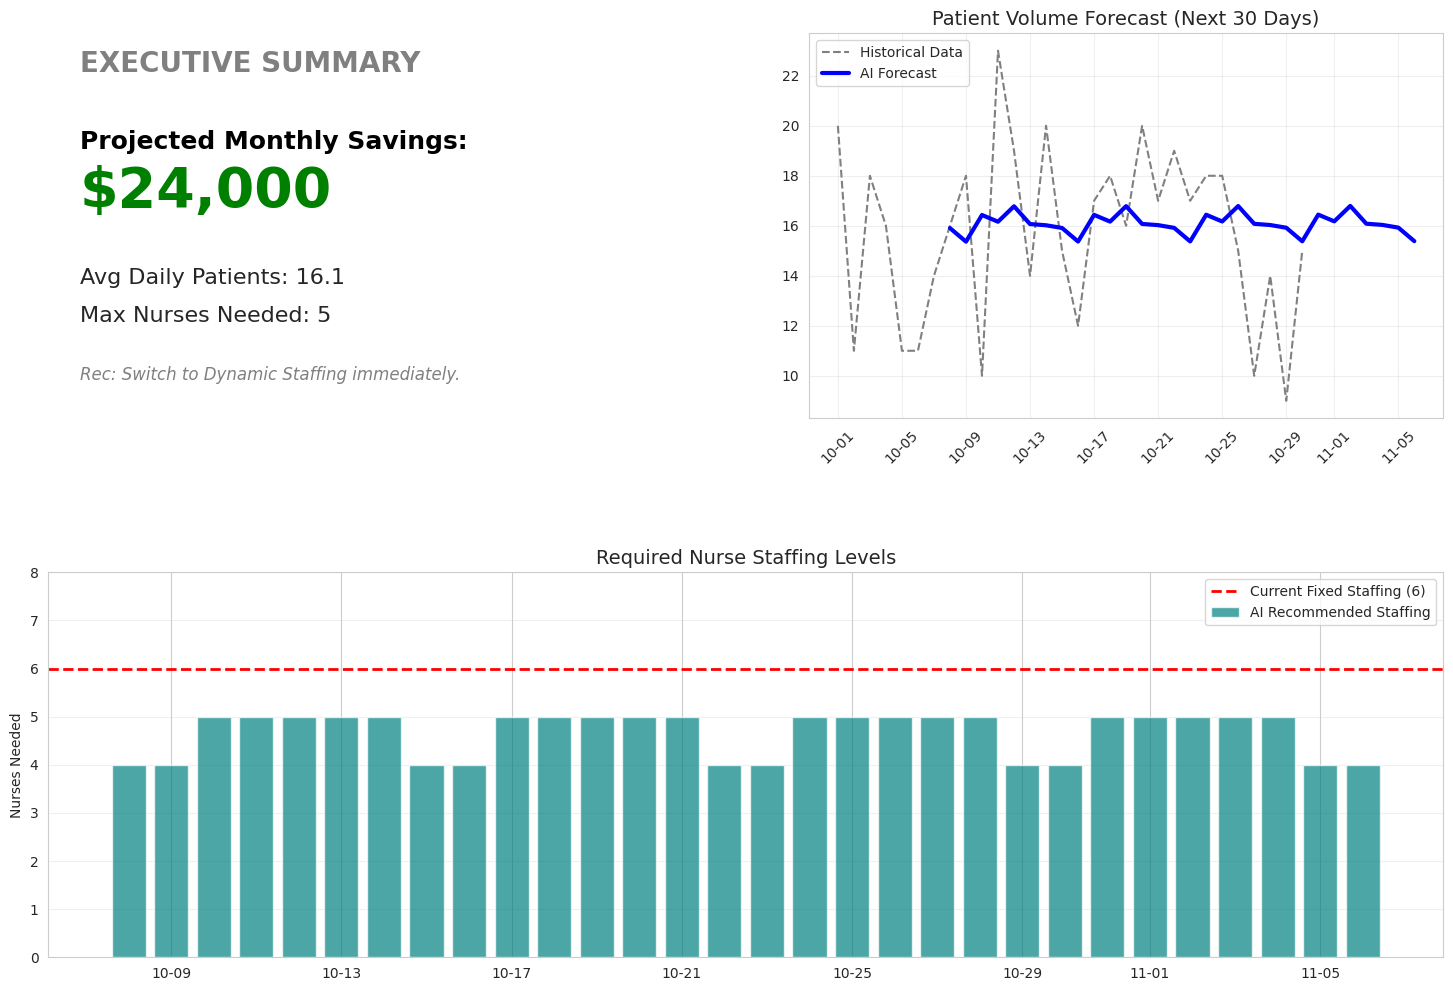

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig = plt.figure(figsize=(18, 12)) # Made it slightly taller
grid = plt.GridSpec(2, 2, hspace=0.4, wspace=0.2)

# --- 1. KPI CARD (Top Left) ---
ax1 = fig.add_subplot(grid[0, 0])
ax1.axis('off')

# Calculate the numbers
total_savings = future['Daily_Savings'].sum()
avg_patients = future['Patient_Count'].mean()
peak_nurse = future['Nurses_Needed'].max()

ax1.text(0.05, 0.90, "EXECUTIVE SUMMARY", fontsize=20, fontweight='bold', color='gray')

ax1.text(0.05, 0.70, "Projected Monthly Savings:", fontsize=18, fontweight='bold', color='black')
ax1.text(0.05, 0.55, f"${total_savings:,.0f}", fontsize=40, fontweight='bold', color='green')

ax1.text(0.05, 0.35, f"Avg Daily Patients: {avg_patients:.1f}", fontsize=16)
ax1.text(0.05, 0.25, f"Max Nurses Needed: {peak_nurse:.0f}", fontsize=16)
ax1.text(0.05, 0.10, "Rec: Switch to Dynamic Staffing immediately.", fontsize=12, style='italic', color='gray')


# --- 2. THE FORECAST CHART (Top Right) ---
ax2 = fig.add_subplot(grid[0, 1])
# Plot History
ax2.plot(history['Date'].tail(30), history['Patient_Count'].tail(30), label='Historical Data', color='gray', linestyle='--')
# Plot Forecast
ax2.plot(future['Date'], future['Patient_Count'], label='AI Forecast', color='blue', linewidth=3)
ax2.set_title("Patient Volume Forecast (Next 30 Days)", fontsize=14)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)


# --- 3. THE STAFFING SCHEDULE (Bottom) ---
ax3 = fig.add_subplot(grid[1, :])
ax3.bar(future['Date'], future['Nurses_Needed'], color='teal', alpha=0.7, label='AI Recommended Staffing')

# Add the Red Line
ax3.axhline(y=6, color='red', linestyle='--', linewidth=2, label='Current Fixed Staffing (6)')
ax3.set_ylim(0, 8)

ax3.set_title("Required Nurse Staffing Levels", fontsize=14)
ax3.set_ylabel("Nurses Needed")
ax3.legend(loc='upper right')
ax3.grid(axis='y', alpha=0.3)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.show()
